In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import copy as cp

# Notebook para comparar f1 entre kriging y GP

In [92]:
# se cargan los datos de entrenamiento
train_data = pd.read_csv('../../GP_Data/cy17_spc_assays_rl6_entry.csv')
train_cols = ['midx','midy','midz','cut']

test_data = pd.read_csv('../../GP_Data/12_BLASTHOLE_ASS_ENTRY.csv')
test_cols = ['POINTEAST','POINTNORTH','POINTRL']

# se definen los estilos de los graficos
jtplot.style(theme='onedork',figsize = (20,10))

In [134]:
# funciones utiles para ahorrar lineas y hacer codigo
# mas legible
def get_years(path_estimacion):
    estimacion_sorted = add_year_month_sorted(path_estimacion)
    df_years = estimacion_sorted['year']
    seen = set()
    YEARS = []
    for item in df_years:
        if item not in seen:
            seen.add(item)
            YEARS.append(item)
    return YEARS
    
def add_year_month_sorted(path_estimacion):
    # se agregan las columans year y month a
    # al archivo dque contiene las estimacines
    estimacion_original = pd.read_csv(path_estimacion)
    
    # solamente se consideran las estimaciones
    # que tienen f1 dado (i.e. no -99) y cut
    # mayor que cero
    estimacion_filtrada = estimacion_original.loc[(estimacion_original['f1'] > 0) & 
                                                  (estimacion_original['cut'] > 0)]
    f1 = estimacion_filtrada['f1'].as_matrix()
    estimacion = cp.copy(estimacion_filtrada)
    estimacion = estimacion.assign(year=((f1-1)/12).astype(int) + 2014)
    estimacion = estimacion.assign(mes=((f1-1)%12 + 1).astype(int))
    estimacion_sorted = estimacion.sort_values('f1',ascending=True)
    return estimacion_sorted


def dicc_error_bloque(path_estimacion):
    estimacion_sorted = add_year_month_sorted(path_estimacion)
    YEARS = get_years(path_estimacion)
    dicc_anual = dict()
    for year in YEARS:
        plt.figure()
        df_by_year = estimacion_sorted.loc[estimacion_sorted['year']==year]
        meses = df_by_year['mes']
        dicc_promedios_mensual = dict()
        for mes in meses:
            cut_mes = df_by_year.loc[df_by_year['mes']==mes]['cut']
            cut_poz_mes =  df_by_year.loc[df_by_year['mes']==mes]['cut_poz']
            cuociente = np.divide(cut_poz_mes, cut_mes)
            promedio_mensual = cuociente.mean()
            dicc_promedios_mensual[mes] = promedio_mensual
        dicc_anual[year] = dicc_promedios_mensual
    return dicc_anual
    #for year,dicc in dicc_anual:
    #    plt.figure()
    #    for mes, promedio in dicc:
    #        plt.plot(mes,promedio)
def dicc_error_volumen(path_estimacion):
    estimacion_sorted = add_year_month_sorted(path_estimacion)
    YEARS = get_years(path_estimacion)
    dicc_anual = dict()
    for year in YEARS:
        plt.figure()
        df_by_year = estimacion_sorted.loc[estimacion_sorted['year']==year]
        meses = df_by_year['mes']
        seen = set()
        MESES = [] # se eliminan los meses repetidos
        for mes in meses:
            if mes not in seen:
                seen.add(mes)
                MESES.append(mes)
        dicc_cuociente_mensual = dict() # mes: cut_poz.mean()/cut.mean()
        for mes in MESES:
            cut_mes = df_by_year.loc[df_by_year['mes']==mes]['cut']
            cut_poz_mes =  df_by_year.loc[df_by_year['mes']==mes]['cut_poz']
            cuociente = np.divide(cut_poz_mes.mean(), cut_mes.mean())
            dicc_cuociente_mensual[mes] = cuociente
        dicc_anual[year] = dicc_cuociente_mensual
    
    _plot_f1(dicc_anual,YEARS)
    return dicc_anual

def _plot_f1(dicc,years):
    df_dicc = pd.DataFrame.from_dict(dicc)
    f1 = df_dicc[years[0]]
    for year in years[1:]:
        f1 = pd.concat([f1,df_dicc[year]],names=['f1'])
    
    f1 = f1.dropna() # elimina todas las filas con Nan
    f1_df = pd.DataFrame(f1.as_matrix(), index=pd.date_range('1/1/'+str(years[0]), 
                                                            periods=f1.shape[0],freq='MS'))
    f1_df.columns = ['f1']
    f1_df.plot(style = 'bo-')
    plt.axhline(y=1.1, color='g', linestyle='-')
    plt.axhline(y=0.9, color='g', linestyle='-')
    return f1_df

# Error por bloque $\frac{1}{N}\sum_{i=1}^N \text{f1}_i$

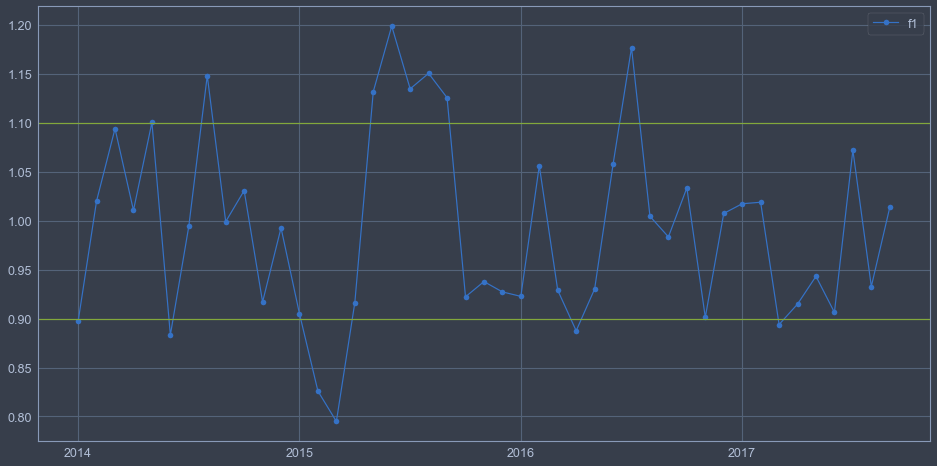

In [103]:
# calcular cuociente de los promedios
path_estimacion = 'mp_test_all_2.csv'
diccionario = dicc_error_volumen(path_estimacion)
plt.show()

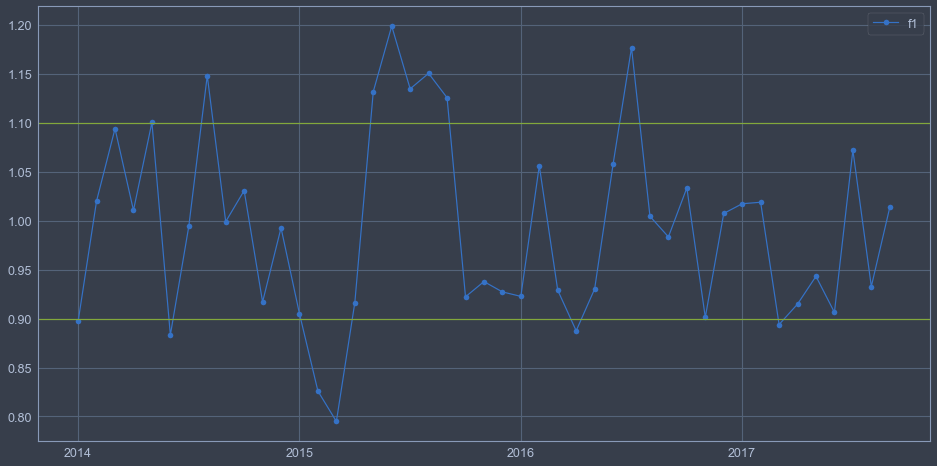

In [141]:
# calcular cuociente de los promedios
path_estimacion = 'mp_test_all_3.csv'
diccionario = dicc_error_volumen(path_estimacion)
plt.show()

In [34]:
estimacion_ordenada = add_year_month_sorted(path_estimacion)
YEARS = get_years(path_estimacion)
estimacion_ordenada
estimacion_ordenada_by_year = estimacion_ordenada.loc[estimacion_ordenada['year']==2017]
estimacion_ordenada_by_year

,xcentre,ycentre,zcentre,minty,cut_poz,cut,f1,year,mes
94525,474735.558,7481732.528,1632.5,20.0,0.046,0.293200,37.0,2017,1
94327,474763.068,7481529.623,1632.5,10.0,0.410,0.741050,37.0,2017,1
94328,474744.301,7481538.680,1632.5,10.0,0.070,0.789000,37.0,2017,1
94526,474763.572,7481728.449,1632.5,10.0,0.225,0.516042,37.0,2017,1
94329,474743.204,7481552.637,1632.5,10.0,0.080,0.484923,37.0,2017,1
94330,474756.264,7481539.620,1632.5,10.0,0.240,0.779412,37.0,2017,1
94326,474780.738,7481534.522,1632.5,20.0,0.350,0.849846,37.0,2017,1
94332,474767.678,7481547.539,1632.5,10.0,0.190,0.781556,37.0,2017,1
94333,474737.067,7481568.095,1632.5,10.0,0.140,0.321138,37.0,2017,1
94334,474731.241,7481551.697,1632.5,10.0,0.060,0.260682,37.0,2017,1


In [8]:
# calcular cuociente y promediar

path_estimacion = 'mp_test_all_2.csv'
diccionario = dicc_error_bloque(path_estimacion)

diccionario

{2014: {1: 0.8901972530257086,
  2: 1.117759910232103,
  3: 1.1103342468848332,
  4: 1.016917826331468,
  5: 1.1340197208550962,
  6: 0.981968427299548,
  7: 0.9368072292232265,
  8: 1.1860813713148026,
  9: 1.073124356025606,
  10: 1.0126203229263682,
  11: 0.9938247634268266,
  12: 0.9248339839169021},
 2015: {1: 0.980259807672499,
  2: 0.8194162754156087,
  3: 0.8279560559688305,
  4: 0.910825536748613,
  5: 1.162959014282541,
  6: 1.284577500750626,
  7: 1.2065832370925613,
  8: 1.1644908217898902,
  9: 1.1743722517631314,
  10: 0.9685290310406914,
  11: 0.9881845185338656,
  12: 0.9274979202351279},
 2016: {1: 0.893225730429489,
  2: 1.0541995212735225,
  3: 0.965153818897986,
  4: 0.9368501340000184,
  5: 1.0757676399021268,
  6: 1.1041436785114649,
  7: 1.265740778218783,
  8: 1.0308820326408514,
  9: 1.0220792839619768,
  10: 1.0901178756423446,
  11: 0.9851860287761648,
  12: 1.0522940558790363},
 2017: {1: 0.9540268716611107,
  2: 1.0222693160495009,
  3: 0.9624626772602631,


In [57]:
df_dicc = pd.DataFrame.from_dict(diccionario)
df_dicc

,2014,2015,2016,2017
1,0.897124,0.904905,0.922690,1.017330
2,1.020237,0.825864,1.056199,1.018849
3,1.094043,0.794924,0.928943,0.893947
4,1.010578,0.916346,0.887546,0.914826
5,1.100454,1.131832,0.930224,0.943186
6,0.883212,1.198832,1.057666,0.906359
7,0.994332,1.134716,1.176798,1.072101
8,1.148259,1.150532,1.004547,0.932773
9,0.999036,1.125697,0.983445,1.013587
10,1.030770,0.922261,1.033585,NaN


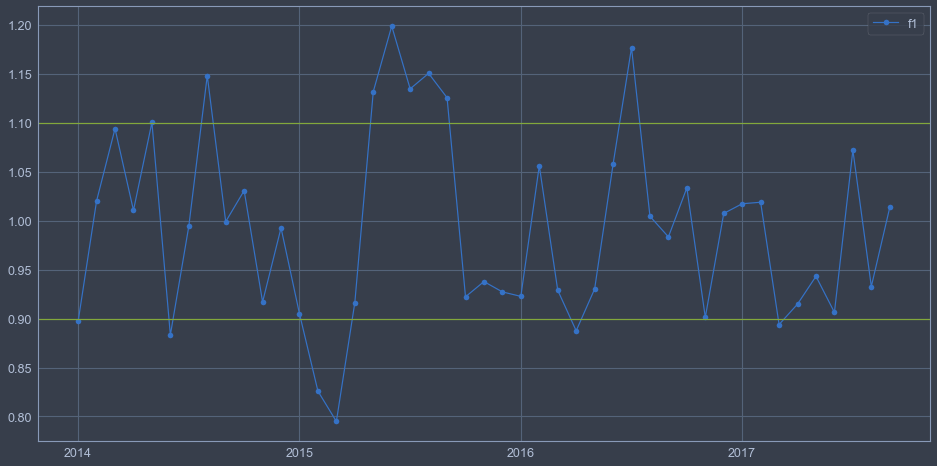

In [102]:
annos = get_years(path_estimacion)
serie_concat = _plot_f1(diccionario,annos)
serie_concat
plt.show()

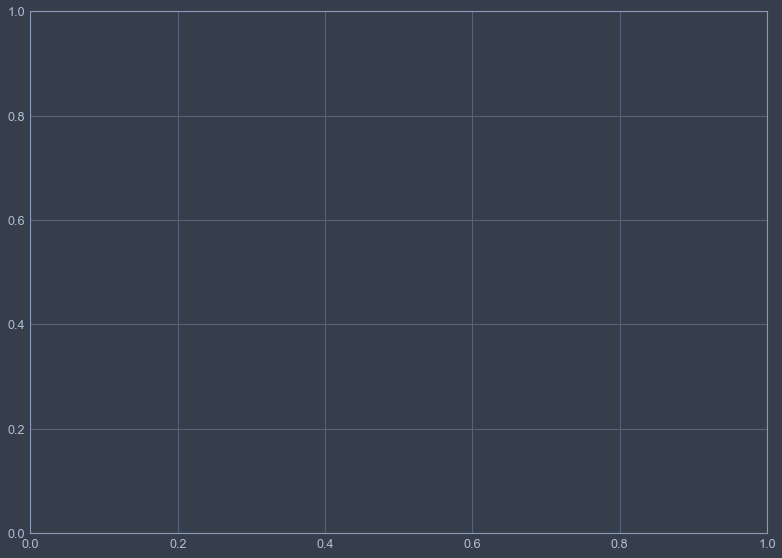

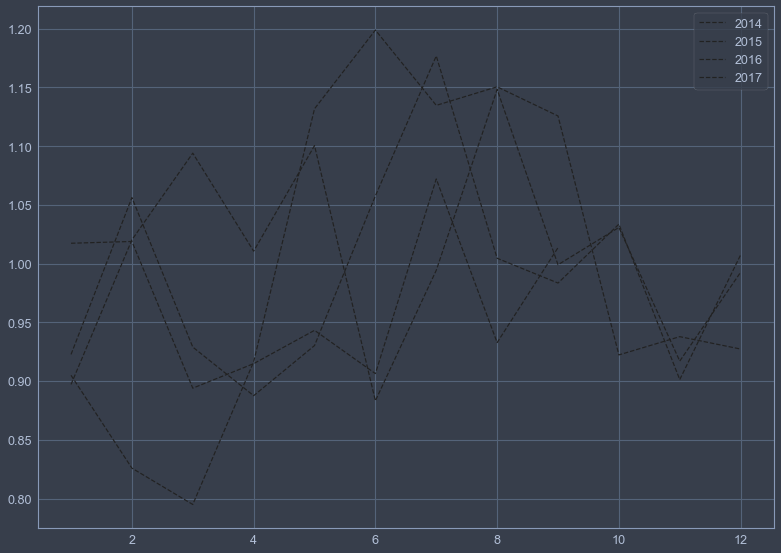

In [39]:
plt.figure(); df_dicc.plot(style='k--', label='Series');
plt.show()

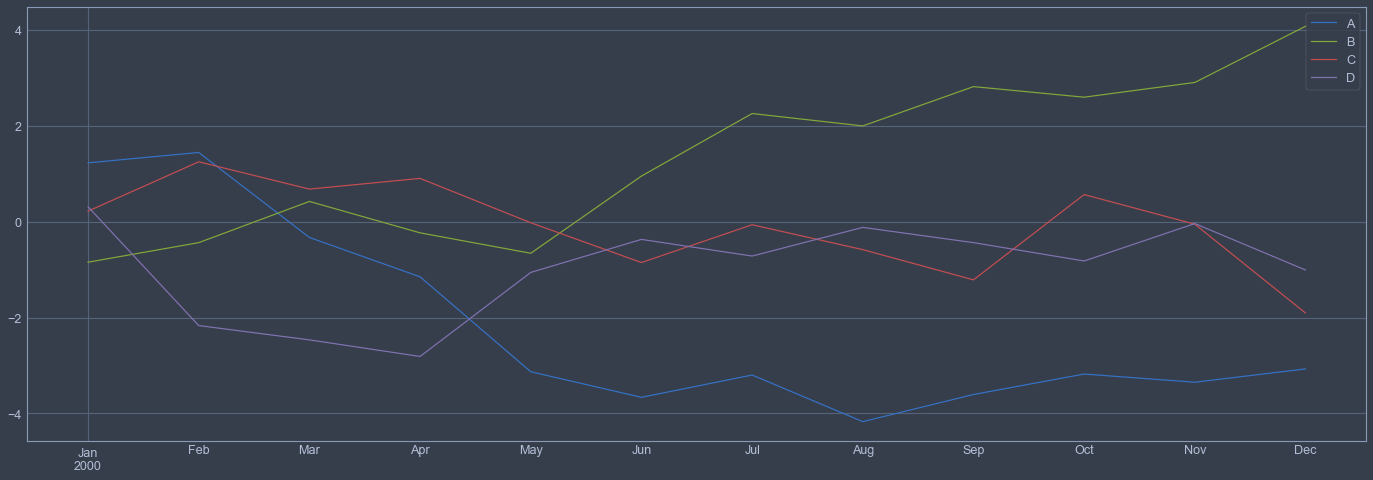

In [90]:
ts = pd.Series(np.random.randn(12), index=pd.date_range('1/1/2000', periods=12,freq='MS'))
ts = ts.cumsum()

df = pd.DataFrame(np.random.randn(12, 4), index=ts.index, columns=list('ABCD'))
df = df.cumsum()
plt.figure(); df.plot();
# plt.axhline(y=1.5, color='r', linestyle='-')
plt.show()

In [50]:
df

,A,B,C,D
2000-01-01,-2.947637,0.125519,-1.946574,-0.792746
2000-02-01,-1.572794,-0.110484,-0.605077,-1.056314
2000-03-01,-0.714567,-1.264310,-0.325535,-0.744359
2000-04-01,-0.531413,-3.782486,-0.893704,-0.789922
2000-05-01,-1.265744,-2.951111,-0.879373,-0.734344
2000-06-01,-2.471932,-3.084903,-0.650972,-1.673811
2000-07-01,-1.771661,-2.744987,-0.000168,-1.638761
2000-08-01,-2.631374,-2.784103,0.065174,-1.888086
2000-09-01,-2.607440,-3.489403,0.694830,-1.953257
2000-10-01,-1.944422,-3.652047,0.944738,-2.471475


In [62]:
toy_list = [1,2]
toy_list[1:]

[2]

In [53]:
path_estimacion = 'mp_test_all_2.csv'
diccionario_vol = dicc_error_volumen(path_estimacion)

diccionario_vol

{2014: {1: 0.89712378915567481,
  2: 1.0202371196219429,
  3: 1.094043245077456,
  4: 1.0105782048844743,
  5: 1.1004535787952607,
  6: 0.88321213132416199,
  7: 0.99433221496141433,
  8: 1.148258955255447,
  9: 0.99903646948195213,
  10: 1.0307701983739701,
  11: 0.91701514836054565,
  12: 0.99264270972682389},
 2015: {1: 0.90490471167172126,
  2: 0.82586436514955297,
  3: 0.79492388487340049,
  4: 0.91634637071399028,
  5: 1.1318319361366453,
  6: 1.1988321854306696,
  7: 1.1347159961769273,
  8: 1.1505320085687518,
  9: 1.1256974101860655,
  10: 0.92226078648438714,
  11: 0.93781086579138584,
  12: 0.92725638181288217},
 2016: {1: 0.92269012044965326,
  2: 1.0561990828890266,
  3: 0.92894292847599569,
  4: 0.88754605704851042,
  5: 0.93022362997383923,
  6: 1.0576657234745959,
  7: 1.1767979975060874,
  8: 1.0045468287965604,
  9: 0.98344542089715037,
  10: 1.0335847022338647,
  11: 0.90127065838923592,
  12: 1.0074317049088179},
 2017: {1: 1.0173297100257079,
  2: 1.018848589980939

In [51]:
# cuantos puntos test no se analizan por falta de f1
estimacion_original = pd.read_csv(path_estimacion)
estimacion_original
estimacion_filtrada = estimacion_original.loc[(estimacion_original['f1'] > 0)]
estimacion_filtrada

,xcentre,ycentre,zcentre,minty,cut_poz,cut,f1
0,475103.993,7481564.021,1572.5,61.0,13.810,1.027211,28.0
1,475013.339,7481534.458,1572.5,30.0,3.450,1.557500,27.0
2,474995.118,7481524.346,1572.5,30.0,3.090,2.073333,27.0
3,475007.115,7481524.089,1572.5,30.0,2.700,2.188588,27.0
4,475043.257,7481530.315,1572.5,30.0,2.690,1.871517,27.0
5,475013.939,7481562.451,1572.5,50.0,2.530,1.029368,27.0
6,475007.415,7481538.085,1572.5,30.0,2.540,1.441125,27.0
7,475073.325,7481533.171,1572.5,30.0,2.570,1.947091,27.0
8,474983.120,7481524.603,1572.5,61.0,2.240,1.382158,27.0
9,475073.925,7481561.165,1572.5,30.0,2.080,1.628222,27.0


In [ ]:
# esta linea solo es para ver si se actualiza en GitHub